# Banking dataset with a `pymc` model

This notebook analyses historic data on banking closures from {cite:t}`richardson2009monetary` and used as a case study for a difference in differences analysis in the excellent book [Mastering Metrics](http://www.masteringmetrics.com) {cite:p}`angrist2014mastering`. Here, we replicate this analysis, but using Bayesian inference.

In [1]:
import arviz as az
import pandas as pd

import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

## Load data

The raw dataset has a `date` column which is just some uninterpretable number - all we need for our analysis is the `year` column. We also have columns `bib6`, `bio6`, `bib8`, `bio8`. We know that the `6` and `8` represent the 6th and 8th Federal Reserve districts, respectively. I assume `bib` means "banks in business", so we'll keep those columns. The data is at daily resolution, but we will convert this to yearly resolution. And from what I can tell from Figure 5.2 of {cite:t}`angrist2014mastering`, they seem to present the _median_ number of banks open per year. Let's load the data up and do those steps.

In [3]:
df = (
    cp.load_data("banks")
    # just keep columns we want
    .filter(items=["bib6", "bib8", "year"])
    # rename to meaningful variables
    .rename(columns={"bib6": "Sixth District", "bib8": "Eighth District"})
    # reduce from daily resolution to examine median banks open by year
    .groupby("year")
    .median()
)

treatment_time = 1930.5

# set treatment time to zero
df.index = df.index - treatment_time
treatment_time = 0

Let's visualise what we have. This matches up exactly with Figure 5.2 of the {cite:t}`angrist2014mastering`.

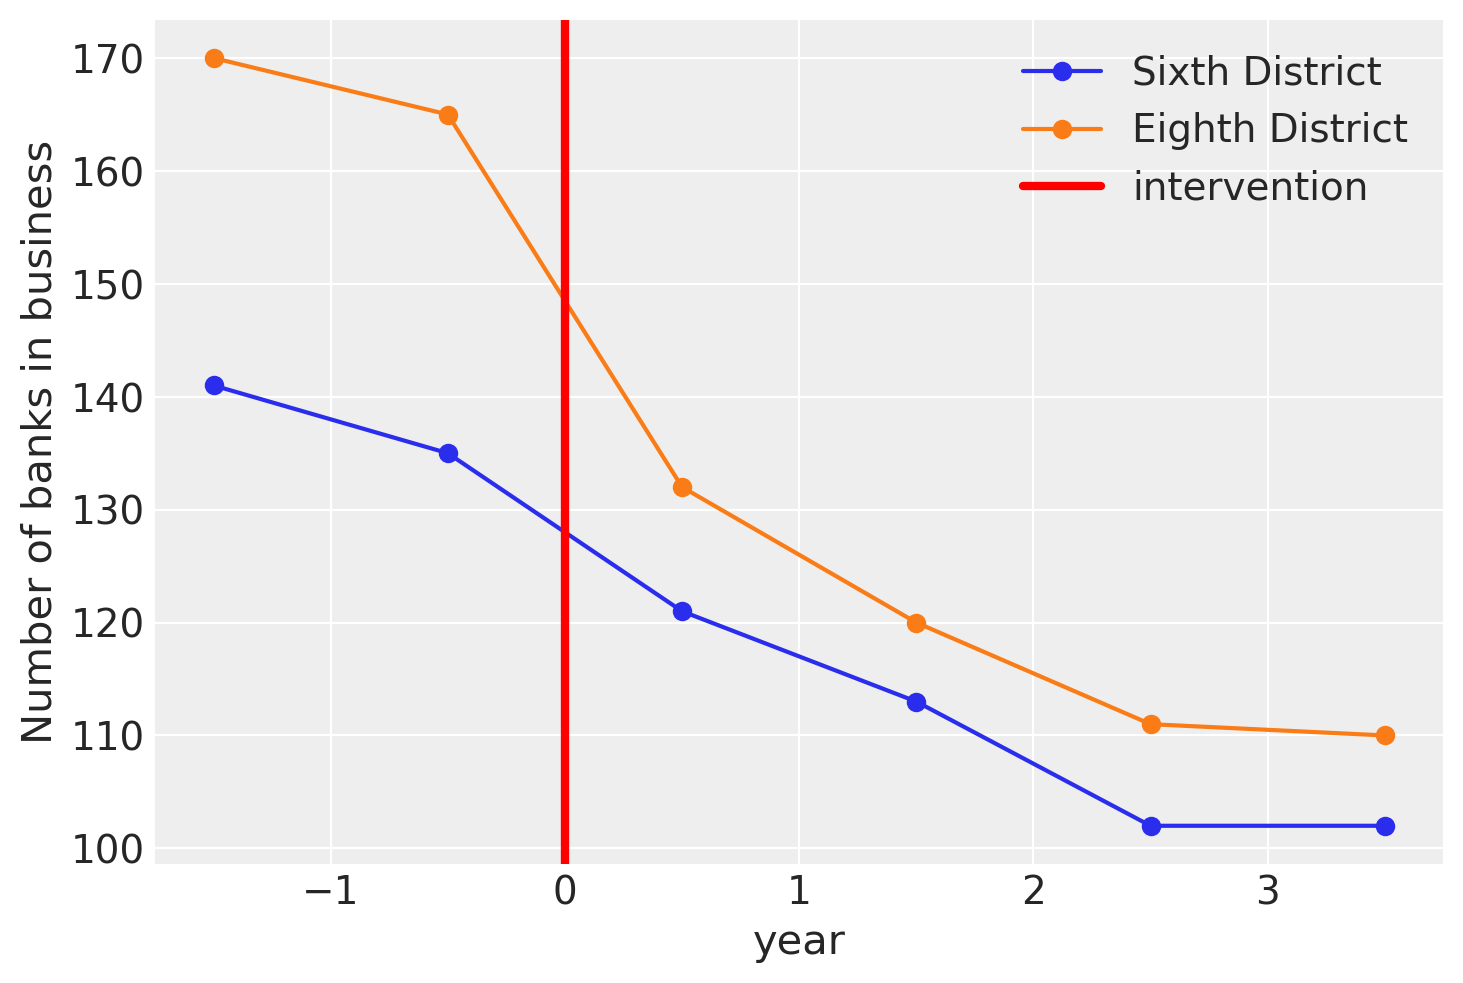

In [4]:
ax = df[["Sixth District", "Eighth District"]].plot(style="o-")
ax.set(ylabel="Number of banks in business")
ax.axvline(x=treatment_time, c="r", lw=3, label="intervention")
ax.legend();

Just a few more final processing steps to make the data amenable to analysis. We will convert from wide form into long form. Then we will add a new column `treated` which indicates the observations where treatment has taken place.

In [5]:
df.reset_index(level=0, inplace=True)
df_long = pd.melt(
    df,
    id_vars=["year"],
    value_vars=["Sixth District", "Eighth District"],
    var_name="district",
    value_name="bib",
).sort_values("year")

# We also need to create a column called `unit` which labels each distinct
# unit. In our case we just have two treatment units (each district). So
# we can build a `unit` column from `district`.
df_long["unit"] = df_long["district"]

# We also need to create a `post_treatment` column to define times after
# the intervention.
df_long["post_treatment"] = df_long.year >= treatment_time
df_long

# Dummy coding for district
df_long = df_long.replace({"district": {"Sixth District": 1, "Eighth District": 0}})
df_long

/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_73369/4155710090.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_long = df_long.replace({"district": {"Sixth District": 1, "Eighth District": 0}})


,year,district,bib,unit,post_treatment
0,-1.5,1,141.0,Sixth District,False
6,-1.5,0,170.0,Eighth District,False
1,-0.5,1,135.0,Sixth District,False
7,-0.5,0,165.0,Eighth District,False
2,0.5,1,121.0,Sixth District,True
8,0.5,0,132.0,Eighth District,True
3,1.5,1,113.0,Sixth District,True
9,1.5,0,120.0,Eighth District,True
4,2.5,1,102.0,Sixth District,True
10,2.5,0,111.0,Eighth District,True


## Analysis 1 - classic 2$\times$2 DiD

First we'll do an analysis just looking at data from 1930 and 1931. This way we just have a single pre-intervention and a single post-intervention measurement.

We will use the formula: `bib ~ 1 + district * post_treatment` which equates to the following model of expected values:

$$
\begin{aligned}
\mu_i & = \beta_0 \\
 & \quad + \beta_{d} \cdot district_i \\
 & \quad + \beta_{p} \cdot post~treatment_i \\
 & \quad + \beta_{\Delta} \cdot district_i \cdot post~treatment_i
\end{aligned}
$$

Let's just run through this to make sure we understand:
* $\mu_i$ is the expected value of the outcome (number of banks in business) for the $i^{th}$ observation.
* $\beta_0$ is an intercept term to capture the basiline number of banks in business of the control group, in the pre-intervention period.
* `district` is a dummy variable, so $\beta_{d}$ will represent a main effect of district, that is any offset of the treatment group relative to the control group.
* `post_treatment` is also a dummy variable which captures any shift in the outcome after the treatment time, regardless of the recieving treatment or not.
* the interaction of the two dummary variables `district:post_treatment` will only take on values of 1 for the treatment group after the intervention. Therefore $\beta_{\Delta}$ will represent our estimated causal effect.

In [6]:
result1 = cp.DifferenceInDifferences(
    df_long[df_long.year.isin([-0.5, 0.5])],
    formula="bib ~ 1 + district * post_treatment",
    time_variable_name="post_treatment",
    group_variable_name="district",
    model=cp.pymc_models.LinearRegression(
        sample_kwargs={"target_accept": 0.98, "random_seed": seed}
    ),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


:::{note}
We have some divergences here, which is a bad sign. This is likely related to the fact that we only have 4 data points but 5 parameters. This is not always a dealbreaker for a Bayesian analysis (because we have priors), nevertheless when we get divergent samples, this is a warning sign.

Using the following code, we can see that we have a classic "funnel problem" as the divergences occur when the sampler is exploring near zero values of the measurement error (the $\sigma$ parameter).

```python
az.plot_pair(result1.idata, var_names="~mu", divergences=True);
```

For 'proper' work, we'd want to fix things to avoid divergences by, for example, exploring different prior distributions for $\sigma$.
:::

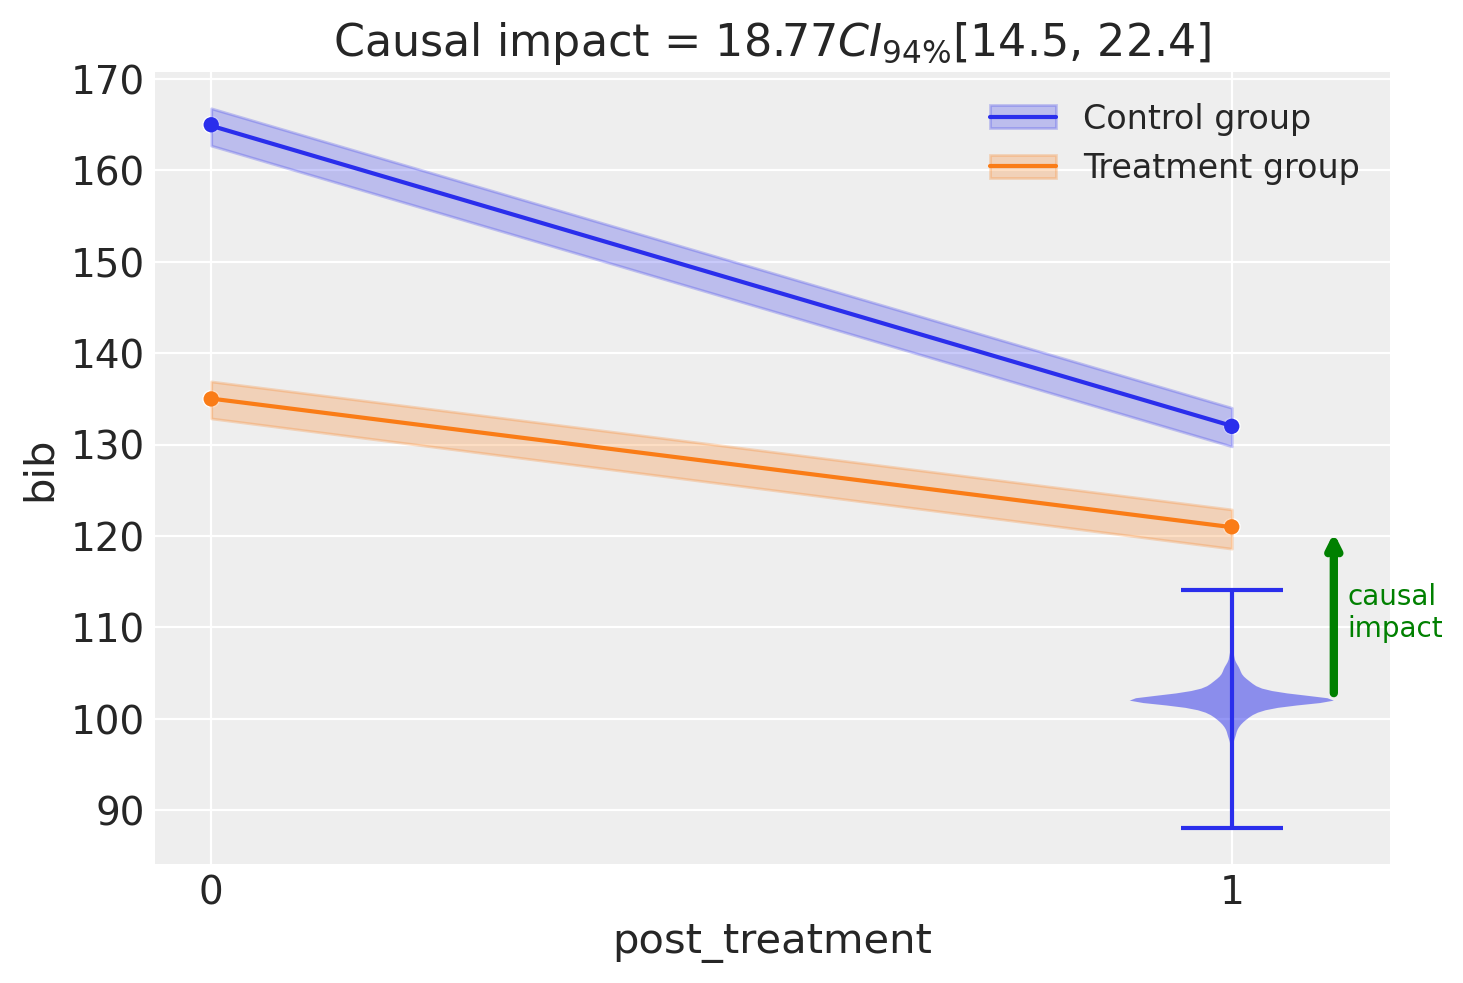

In [7]:
fig, ax = result1.plot(round_to=3)

In [8]:
result1.summary()

===========================Difference in Differences============================
Formula: bib ~ 1 + district * post_treatment

Results:
Causal impact = 18.77$CI_{94\%}$[15, 22]
Model coefficients:
    Intercept                        165, 94% HDI [163, 167]
    post_treatment[T.True]           -33, 94% HDI [-36, -30]
    district                         -30, 94% HDI [-32, -27]
    district:post_treatment[T.True]  19, 94% HDI [15, 22]
    sigma                            0.84, 94% HDI [0.085, 2.2]


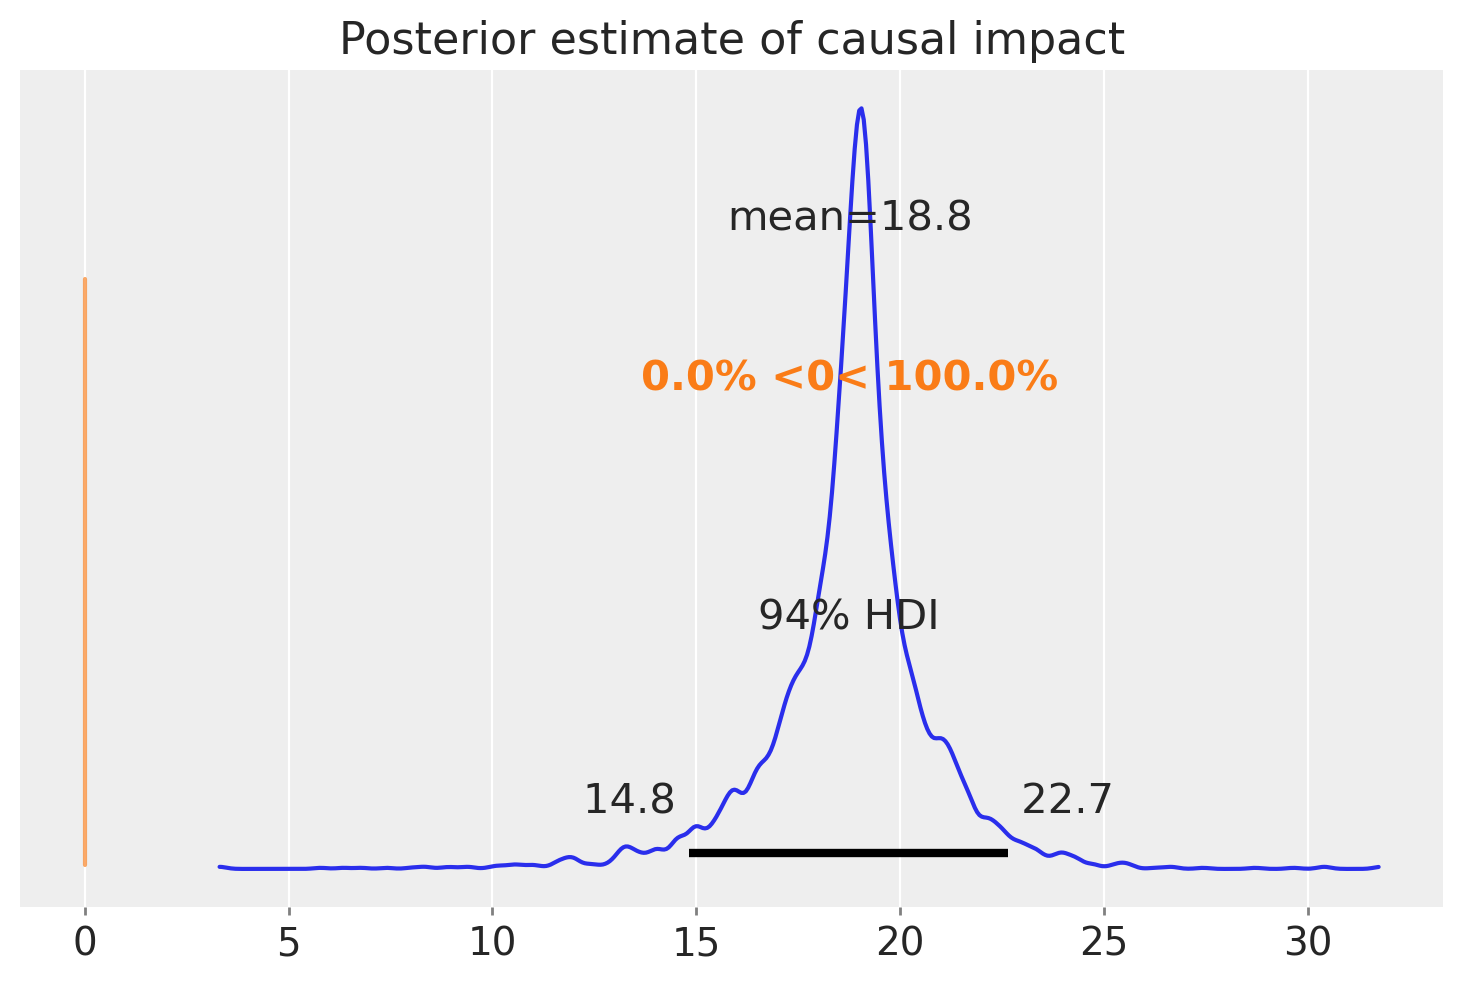

In [9]:
ax = az.plot_posterior(result1.causal_impact, ref_val=0, round_to=3)
ax.set(title="Posterior estimate of causal impact");

## Analysis 2 - DiD with multiple pre/post observations

Now we'll do a difference in differences analysis of the full dataset. This approach has similarities to {term}`CITS` (Comparative Interrupted Time-Series) with a single control over time. Although slightly abitrary, we distinguish between the two techniques on whether there is enough time series data for CITS to capture the time series patterns.

We will use the formula: `bib ~ 1 + year + district*post_treatment` which equates to the following model of expected values:

$$
\begin{aligned}
\mu_i & = \beta_0 \\
 & \quad + \beta_{y} \cdot year_i \\
 & \quad + \beta_{d} \cdot district_i \\
 & \quad + \beta_{p} \cdot post~treatment_i \\
 & \quad + \beta_{\Delta} \cdot district_i \cdot post~treatment_i
\end{aligned}
$$

The only change here compared to the classic 2$\times$2 DiD model above is the addition of a main effect of `year`. Because this is coded numerically (not categorically) this can capture any linear changes in the outcome variable over time.

In [10]:
result2 = cp.DifferenceInDifferences(
    df_long,
    formula="bib ~ 1 + year + district*post_treatment",
    time_variable_name="year",
    group_variable_name="district",
    model=cp.pymc_models.LinearRegression(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


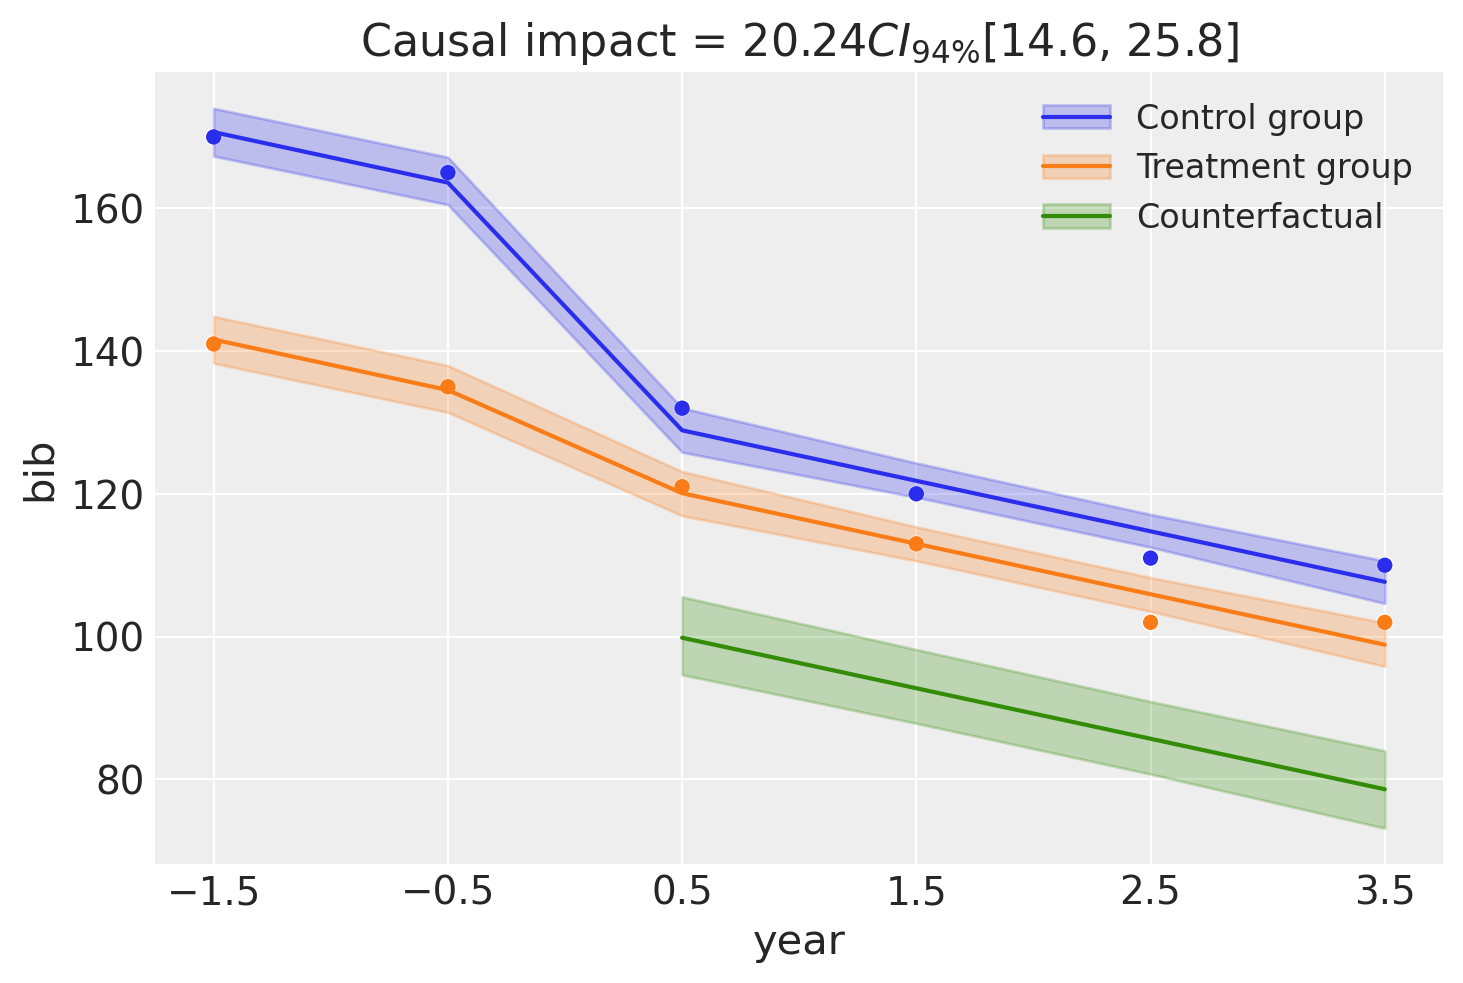

In [11]:
fig, ax = result2.plot(round_to=3)

In [12]:
result2.summary()

===========================Difference in Differences============================
Formula: bib ~ 1 + year + district*post_treatment

Results:
Causal impact = 20.24$CI_{94\%}$[15, 26]
Model coefficients:
    Intercept                        160, 94% HDI [157, 164]
    post_treatment[T.True]           -28, 94% HDI [-33, -22]
    year                             -7.1, 94% HDI [-8.5, -5.7]
    district                         -29, 94% HDI [-34, -24]
    district:post_treatment[T.True]  20, 94% HDI [15, 26]
    sigma                            2.4, 94% HDI [1.7, 3.2]


By looking at the interaction term, which captures the causal impact of the intervention, we can see that it looks like about 20 banks were saved by the intervention. Though there is some uncertainty around this, we can see the full posterior estimate of this impact below.

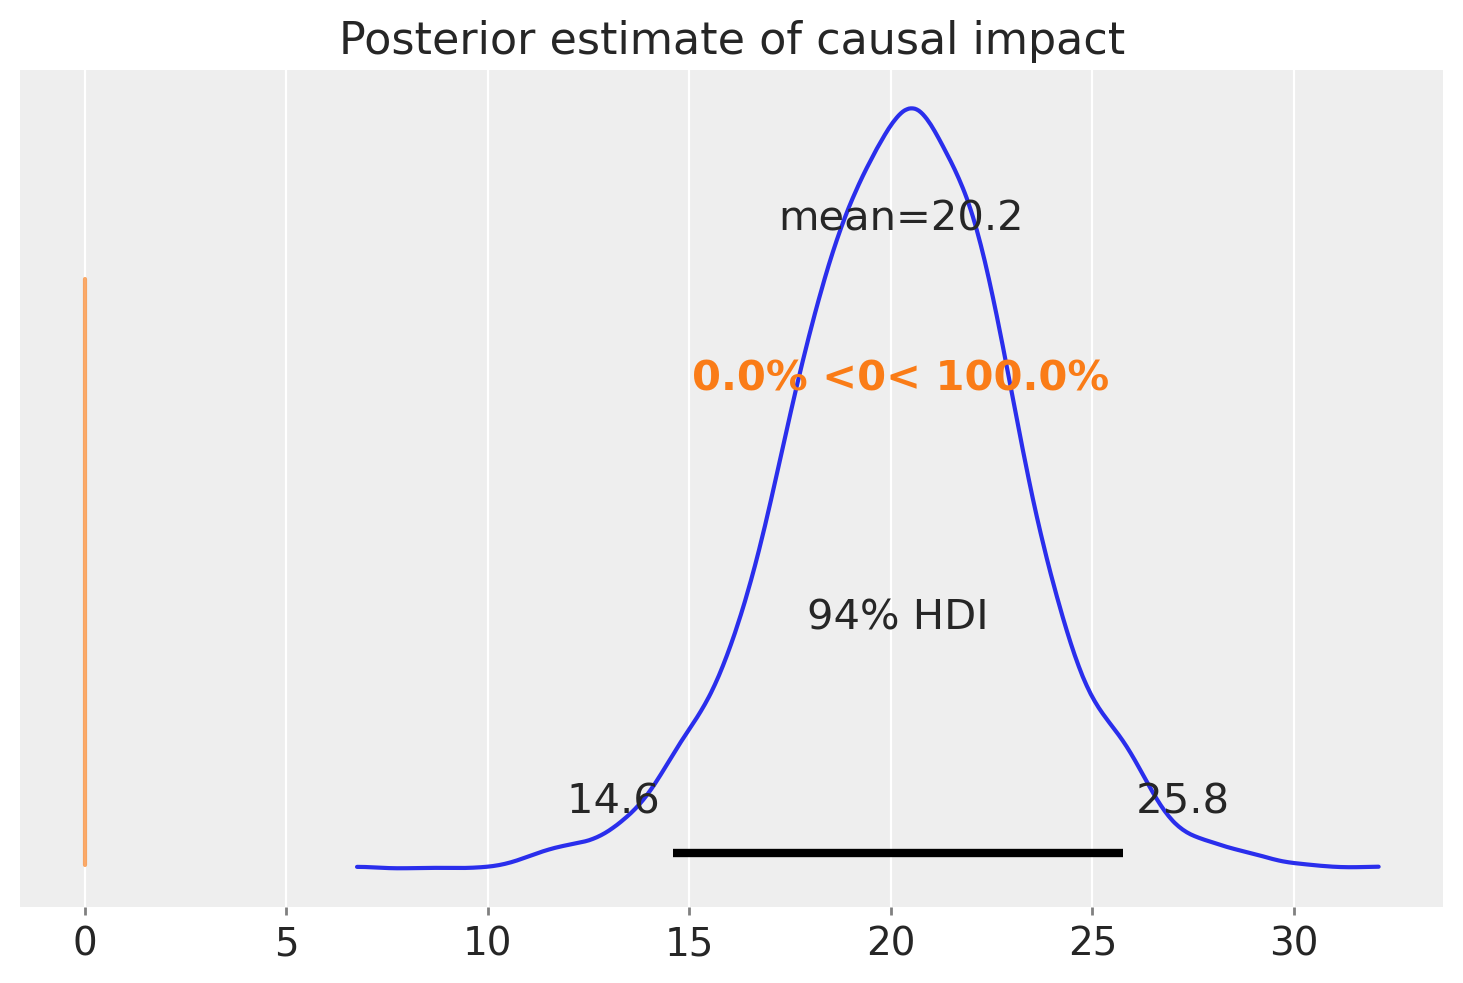

In [13]:
ax = az.plot_posterior(result2.causal_impact, ref_val=0, round_to=3)
ax.set(title="Posterior estimate of causal impact");

## References
:::{bibliography}
:filter: docname in docnames
:::